# IceCube - EDA

## Load Data

In [1]:
%cd ..

/home/jovyan/ice-cube


In [2]:
import sys

sys.path.append(".")

In [3]:
import logging

logging.basicConfig(
    # filename=__file__.replace('.py', '.log'),
    level=logging.getLevelName("INFO"),
    format="%(asctime)s [%(levelname)s] [%(module)s] %(message)s",
)

log = logging.getLogger(__name__)

In [4]:
import glob
import os
import re

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import scipy.stats as stats
import seaborn as sns
from omegaconf import OmegaConf
from src.load_data import LoadData
from src.utils import choice_seed, df_stats, fix_seed

# from pandas_profiling import ProfileReport
# from src.get_score import get_score

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_colwidth", None)

In [5]:
# Competition specific packages
import os
import sqlite3
from typing import Any, Dict, List, Optional

import pyarrow.parquet as pq
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# import sqlalchemy
# import graphnet
# from graphnet.data.sqlite.sqlite_utilities import create_table

In [6]:
c_main = OmegaConf.load("./config/main.yaml")
c_data = OmegaConf.load("./config/data.yaml")
c = OmegaConf.merge(c_main, c_data)

fix_seed(choice_seed(c))

2023-02-27 13:09:12,270 [INFO] [utils] Fix seed: 440


In [7]:
input = LoadData(c, use_fold=False, do_preprocess=False)

2023-02-27 13:09:12,276 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/train_meta.parquet
2023-02-27 13:09:20,410 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/test_meta.parquet
2023-02-27 13:09:20,416 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/sample_submission.parquet
2023-02-27 13:09:20,419 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv


In [8]:
[col for col in dir(input) if not col.startswith("__")]

['c', 'sample_submission', 'sensor_geometry', 'test_meta', 'train_meta']

## Check Data

In [9]:
input.sample_submission.shape

(3, 3)

In [10]:
input.sample_submission

,event_id,azimuth,zenith
0,2092,1,1
1,7344,1,1
2,9482,1,1


In [11]:
input.sensor_geometry.shape

(5160, 4)

In [12]:
input.sensor_geometry

,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95
...,...,...,...,...
5155,5155,-10.97,6.72,-472.39
5156,5156,-10.97,6.72,-479.39
5157,5157,-10.97,6.72,-486.40
5158,5158,-10.97,6.72,-493.41


In [13]:
input.test_meta.shape

(3, 4)

In [14]:
input.test_meta

,batch_id,event_id,first_pulse_index,last_pulse_index
0,661,2092,0,298
1,661,7344,299,334
2,661,9482,335,377


In [15]:
input.train_meta.shape

(131953924, 6)

In [16]:
input.train_meta

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117
...,...,...,...,...,...,...
131953919,660,2147483597,24339210,24339349,5.895612,0.333071
131953920,660,2147483603,24339350,24339383,3.273695,1.503301
131953921,660,2147483617,24339384,24339424,2.945376,1.723253
131953922,660,2147483626,24339425,24339499,1.616582,1.937025


## Read single batch

In [17]:
batch_num = 1
batch = pd.read_parquet(
    os.path.join(c.data.dir.input_train, f"batch_{batch_num}.parquet")
).reset_index()

In [18]:
batch.shape

(32792416, 5)

In [19]:
batch

,event_id,sensor_id,time,charge,auxiliary
0,24,3918,5928,1.325,True
1,24,4157,6115,1.175,True
2,24,3520,6492,0.925,True
3,24,5041,6665,0.225,True
4,24,2948,8054,1.575,True
...,...,...,...,...,...
32792411,3266196,1961,17617,0.975,True
32792412,3266196,36,17705,0.625,True
32792413,3266196,356,18192,0.725,True
32792414,3266196,2826,18609,0.575,True


In [20]:
batch = pd.merge(batch, input.sensor_geometry, on="sensor_id")

In [21]:
batch

,event_id,sensor_id,time,charge,auxiliary,x,y,z
0,24,3918,5928,1.325,True,303.41,335.64,206.58
1,2743,3918,10813,0.975,True,303.41,335.64,206.58
2,3007,3918,10290,0.925,False,303.41,335.64,206.58
3,3007,3918,10515,0.625,False,303.41,335.64,206.58
4,3007,3918,10688,0.925,False,303.41,335.64,206.58
...,...,...,...,...,...,...,...,...
32792411,3261719,1835,15175,0.475,True,-570.90,-125.14,-96.12
32792412,3263862,1835,23327,1.075,False,-570.90,-125.14,-96.12
32792413,3263862,1835,23522,0.575,False,-570.90,-125.14,-96.12
32792414,3264992,1835,13440,1.025,False,-570.90,-125.14,-96.12


In [22]:
batch_event = batch[(batch["event_id"] == 59)] #  & (batch["auxiliary"] == False)

In [23]:
batch_event.head()

,event_id,sensor_id,time,charge,auxiliary,x,y,z
605136,59,4685,6601,1.225,True,31.25,-72.93,138.23
611588,59,3925,6896,0.775,True,303.41,335.64,87.44
617220,59,15,7826,0.325,True,-256.14,-521.08,240.72
622120,59,2583,7866,1.275,True,-156.23,43.37,449.77
622121,59,2583,11861,0.275,True,-156.23,43.37,449.77


In [24]:
batch_event["auxiliary"].value_counts()

True     23
False    13
Name: auxiliary, dtype: int64

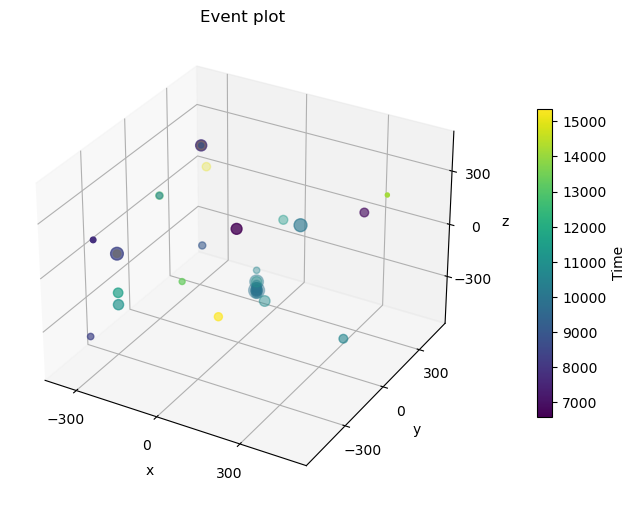

In [25]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")
ax.set_title("Event plot")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xticks([-600, -300, 0.0, 300, 600])
ax.set_yticks([-600, -300, 0.0, 300, 600])
ax.set_zticks([-600, -300, 0.0, 300, 600])

# 散布図を描画
scatter = ax.scatter(
    batch_event["x"],
    batch_event["y"],
    batch_event["z"],
    s=batch_event["charge"] * 50,
    c=batch_event["time"],
)

cbar = fig.colorbar(scatter, shrink=0.5, pad=0.1)
cbar.set_label("Time")

plt.show()